# Alpaca Hum Segmentation – Per-tape Insights

**Notebook goal** – Load `metrics_per_tape.csv` produced by `evaluate_benchmark.py` and explore model performance variability *across individual tapes*:

* Distribution of F1 / precision / recall per model
* Heat-map of F1 (<code>tape × variant</code>)
* Precision–Recall scatter (one marker = one <code>model, variant, tape</code>)
* Boundary-error (Δstart/Δend) distributions per model
* Identify the hardest and easiest tapes

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from natsort import natsorted
import numpy as np
import math

sns.set_context("talk")

In [2]:
# ⇩ adjust to wherever you saved the file produced by evaluate_benchmark.py
METRICS_CSV = Path("/Users/danie/repos/alpaca-segmentation/data_postprocessing/BENCHMARK/metrics_per_tape.csv")
assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

In [3]:
df = pd.read_csv(METRICS_CSV)
df = df.set_index(["model", "variant"])
df = df.loc[natsorted(df.index)].reset_index()


def parse_variant_tag(tag: str):
    """Return seq_len (s), hop (s), threshold (float) from a variant tag."""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", tag)
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000  # back to seconds
    hop = int(m[2]) / 1000
    th  = int(m[3]) / 100
    return seq, hop, th

df[["seq_len_s", "hop_s", "threshold"]] = (
    df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
)

display(df.head())

,model,variant,n_gt,n_pred,tp,fp,fn,precision,recall,f1,...,recall_q1,f1_q1,recall_q2,f1_q2,recall_q3,f1_q3,tape,seq_len_s,hop_s,threshold
0,v1_clipwise_balanced_nph_0.5,len400_hop050_th10,1,1434,0,1434,1,0.000000,0.0,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,388_20250204.wav,0.4,0.05,0.1
1,v1_clipwise_balanced_nph_0.5,len400_hop050_th10,0,1412,0,1412,0,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,388_20250204_2nd_Obs.wav,0.4,0.05,0.1
2,v1_clipwise_balanced_nph_0.5,len400_hop050_th10,7,1114,0,1114,7,0.000000,0.0,0.000000,...,0.0,NaN,0.0,NaN,NaN,NaN,4212_20250205.wav,0.4,0.05,0.1
3,v1_clipwise_balanced_nph_0.5,len400_hop050_th10,1,404,1,403,0,0.002475,1.0,0.004938,...,NaN,NaN,NaN,NaN,1.0,1.0,7919_20250203.wav,0.4,0.05,0.1
4,v1_clipwise_balanced_nph_0.5,len400_hop050_th10,1,1078,0,1078,1,0.000000,0.0,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,PINK_20250203.wav,0.4,0.05,0.1


## 3 · Recall heat-map (tape × variant)

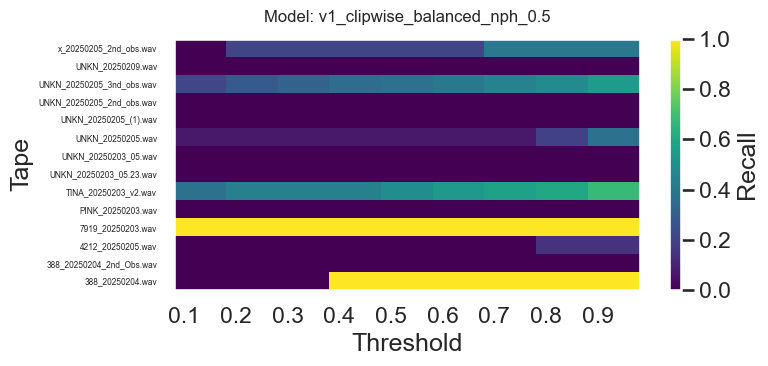

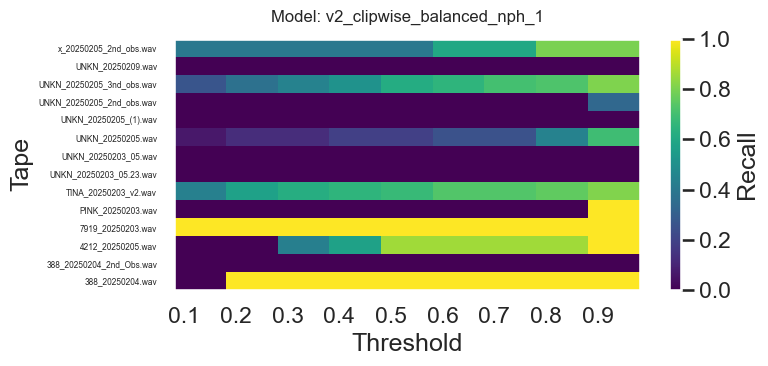

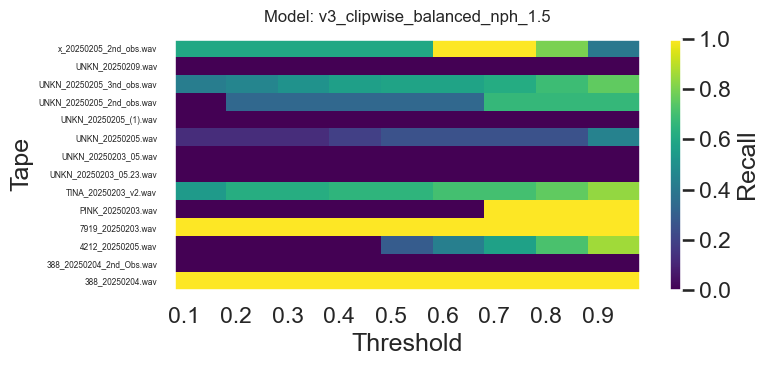

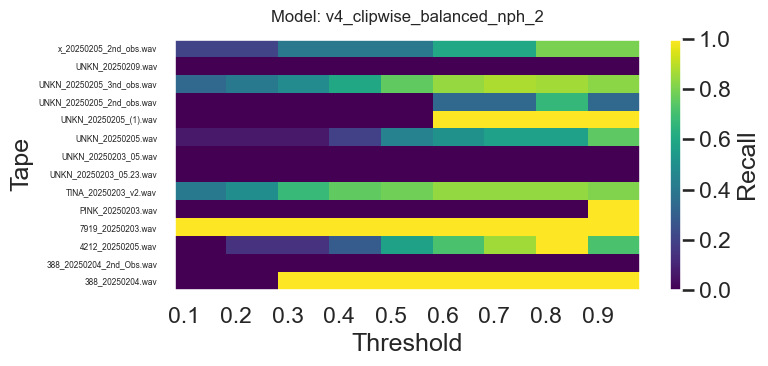

In [4]:
# ── for each model, make its own heatmap ──
models = df["model"].unique()

for model in models:
    sub = df[df["model"] == model]
    pivot = sub.pivot_table(
        index="tape",
        columns="threshold",
        values="recall",
        aggfunc="mean"
    ).sort_index()

    tapes      = pivot.index.tolist()
    thresholds = pivot.columns.tolist()
    Z          = pivot.values

    fig, ax = plt.subplots(figsize=(8, max(4, len(tapes)*0.2)))
    c = ax.pcolormesh(
        np.arange(len(thresholds)+1),
        np.arange(len(tapes)+1),
        Z,
        shading="auto",
        cmap="viridis"    # perceptually uniform, visually appealing
    )
    fig.colorbar(c, ax=ax, label="Recall")

    # ticks at center of each cell
    ax.set_xticks(np.arange(len(thresholds)) + 0.5)
    ax.set_xticklabels(thresholds, ha="right")
    ax.set_yticks(np.arange(len(tapes)) + 0.5)
    ax.set_yticklabels(tapes, fontsize=6)

    ax.set_title(f"Model: {model}", fontsize=12, pad=12)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Tape")

    plt.tight_layout()
    plt.show()

## 5 · Hardest & easiest tapes

In [5]:
# Mean F1 over variants for each tape – lower = harder
tape_mean = df.groupby("tape")["recall"].mean()

hardest = tape_mean.nsmallest(10)
easiest = tape_mean.nlargest(10)

print("### Hardest tapes (mean F1)\n", hardest)
print("\n### Easiest tapes (mean F1)\n", easiest)

### Hardest tapes (mean F1)
 tape
388_20250204_2nd_Obs.wav     0.000000
UNKN_20250203_05.23.wav      0.000000
UNKN_20250203_05.wav         0.000000
UNKN_20250209.wav            0.000000
UNKN_20250205_(1).wav        0.111111
PINK_20250203.wav            0.138889
UNKN_20250205_2nd_obs.wav    0.157407
UNKN_20250205.wav            0.236111
4212_20250205.wav            0.361111
x_20250205_2nd_obs.wav       0.488889
Name: recall, dtype: float64

### Easiest tapes (mean F1)
 tape
7919_20250203.wav            1.000000
388_20250204.wav             0.833333
TINA_20250203_v2.wav         0.639640
UNKN_20250205_3nd_obs.wav    0.543860
x_20250205_2nd_obs.wav       0.488889
4212_20250205.wav            0.361111
UNKN_20250205.wav            0.236111
UNKN_20250205_2nd_obs.wav    0.157407
PINK_20250203.wav            0.138889
UNKN_20250205_(1).wav        0.111111
Name: recall, dtype: float64


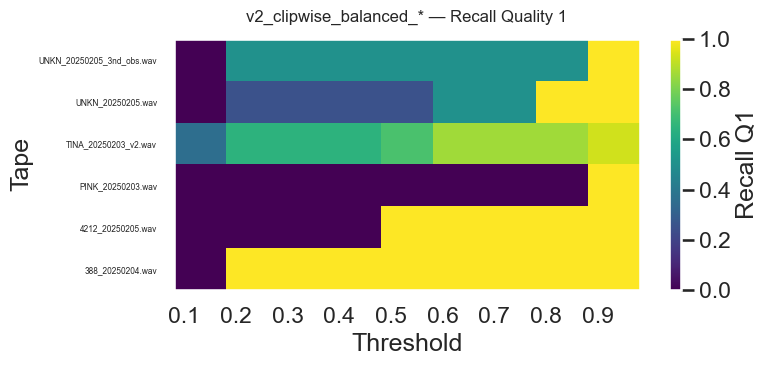

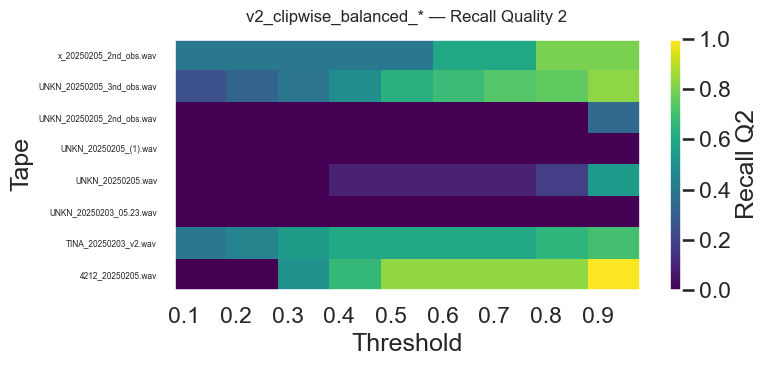

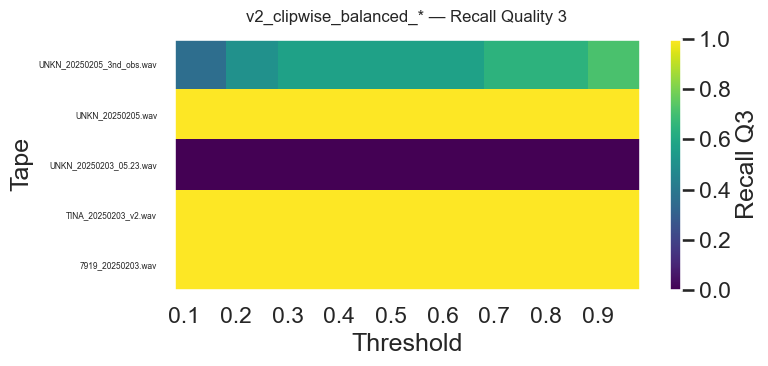

In [6]:
# ── Quality‐specific heatmaps for v2_clipwise_balanced_* ──

# 1) Filter to just that model family
mask = df['model'].str.startswith('v2_clipwise_balanced_')
sub = df[mask]

# 2) Loop over quality levels 1,2,3
qualities = [1, 2, 3]
for q in qualities:
    recall_col = f'recall_q{q}'
    
    # Pivot: rows=tape, cols=threshold
    pivot = sub.pivot_table(
        index='tape',
        columns='threshold',
        values=recall_col,
        aggfunc='mean'
    ).sort_index()

    tapes      = pivot.index.tolist()
    thresholds = pivot.columns.tolist()
    Z          = pivot.values

    # Mask NaNs so they plot as fully transparent
    Z_masked = np.ma.masked_invalid(Z)

    fig, ax = plt.subplots(figsize=(8, max(4, len(tapes)*0.2)))
    cmap = plt.cm.viridis
    cmap.set_bad(alpha=0)   # make missing‐data cells transparent

    c = ax.pcolormesh(
        np.arange(len(thresholds)+1),
        np.arange(len(tapes)+1),
        Z_masked,
        shading='auto',
        cmap=cmap
    )
    fig.colorbar(c, ax=ax, label=f'Recall Q{q}')

    # Center ticks in each cell
    ax.set_xticks(np.arange(len(thresholds)) + 0.5)
    ax.set_xticklabels(thresholds, ha='right')
    ax.set_yticks(np.arange(len(tapes)) + 0.5)
    ax.set_yticklabels(tapes, fontsize=6)

    ax.set_title(f"v2_clipwise_balanced_* — Recall Quality {q}", fontsize=12, pad=12)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Tape")

    plt.tight_layout()
    plt.show()